# Análise exploratória dos dados

## Importando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('poster')
plt.style.use('seaborn-poster')
sns.set_style("ticks", {'axes.facecolor':'#fff2e8', 'figure.facecolor':'#ffead8'})
sns.set_palette("colorblind")

## Arranjando os dados

In [2]:
import pandas as pd

df = pd.read_excel('df_livros.xlsx')

df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('isbn', axis=1, inplace=True)
df = df.convert_dtypes(convert_floating=False)

#df.dropna(inplace=True)

In [3]:
# Removendo livros vendidos em Box
df_analise = df[~df.titulo.str.contains("Box")]

# Removendo livros com menos de 50 avaliações e sem preço.
df_analise = df_analise.loc[(df_analise['avaliacoes'] > 50)]

## Matriz de correlação

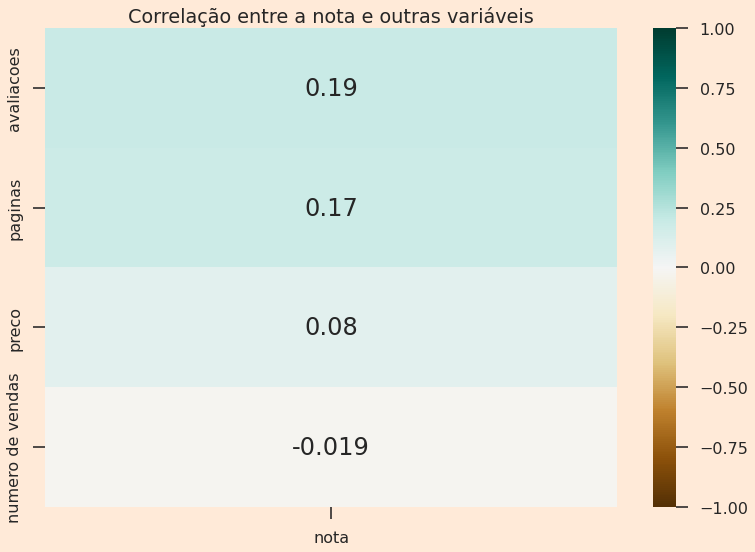

In [4]:
#sns.heatmap(df_analise.corr(), annot=True, vmin=-1, vmax=1, cmap='BrBG')

corr = sns.heatmap(df.corr()[['nota']].drop('nota', axis=0).sort_values(by='nota', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.title('Correlação entre a nota e outras variáveis')

plt.show()

Não existe uma correlação linear forte entre a nota e as variáveis número de avaliaçõeos, páginas, número de vendas e preço.

## Gráficos

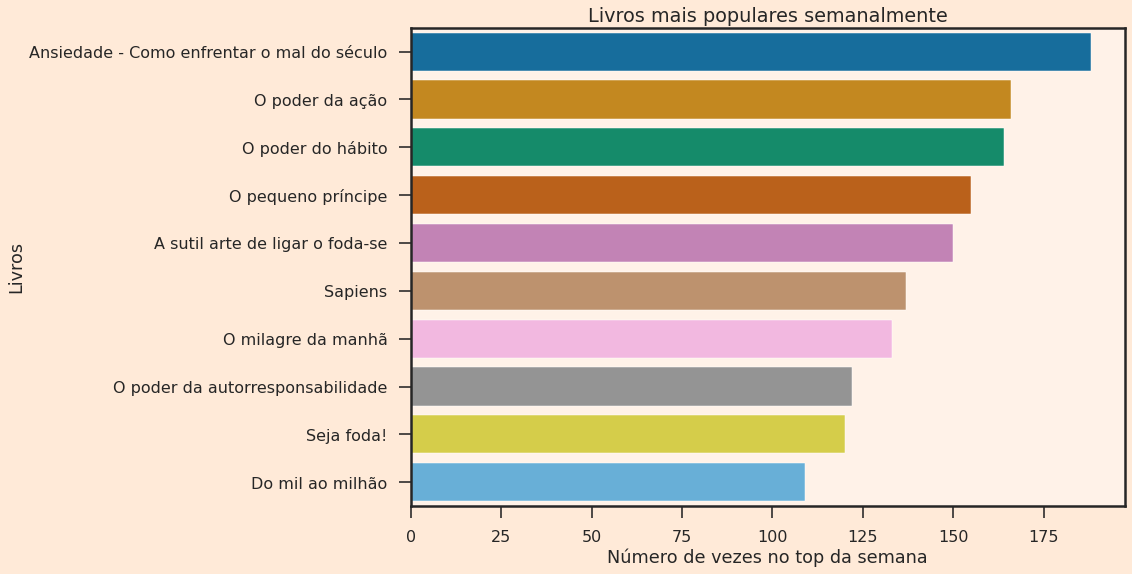

In [5]:
sns.barplot(x = df_analise['titulo'].value_counts()[:10],
            y = df_analise['titulo'].value_counts()[:10].index)

plt.title("Livros mais populares semanalmente")
plt.xlabel("Número de vezes no top da semana")
plt.ylabel("Livros")
plt.show()

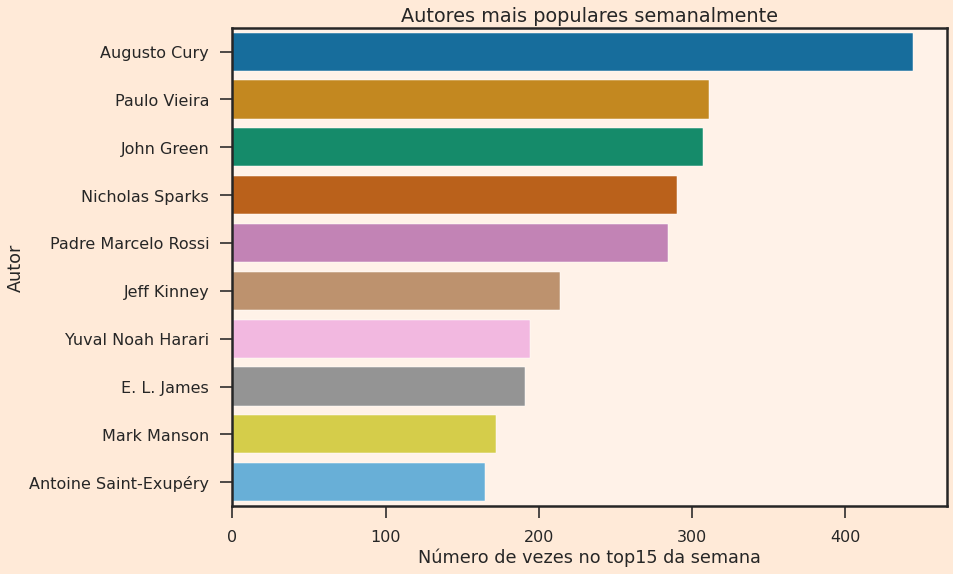

In [6]:
sns.barplot(x = df_analise['autor'].value_counts()[:10],
            y = df_analise['autor'].value_counts()[:10].index)

plt.title("Autores mais populares semanalmente")
plt.xlabel("Número de vezes no top15 da semana")
plt.ylabel("Autor")
plt.show()

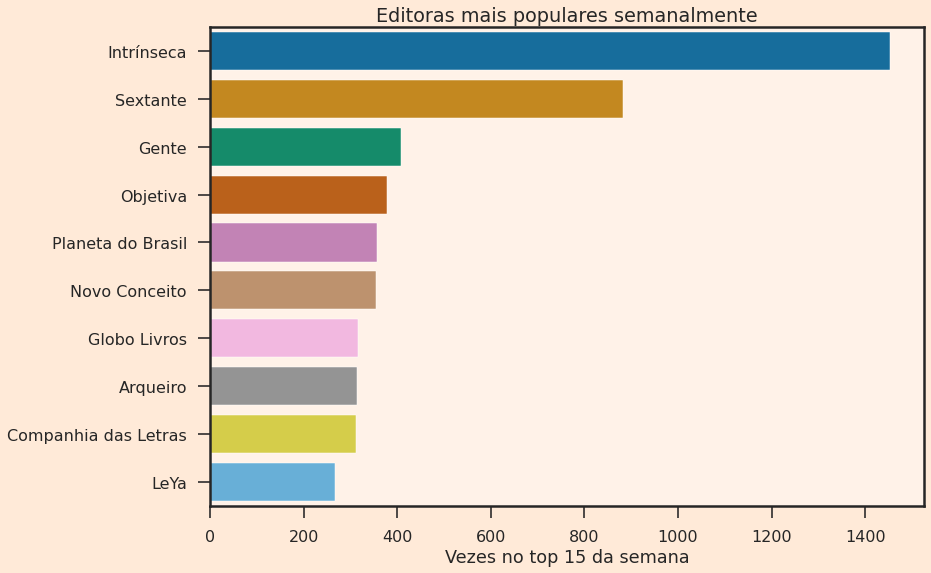

In [7]:
sns.barplot(x = df_analise['editora'].value_counts()[:10],
            y = df_analise['editora'].value_counts()[:10].index)

plt.title("Editoras mais populares semanalmente")
plt.xlabel("Vezes no top 15 da semana")
plt.ylabel("")
plt.show()

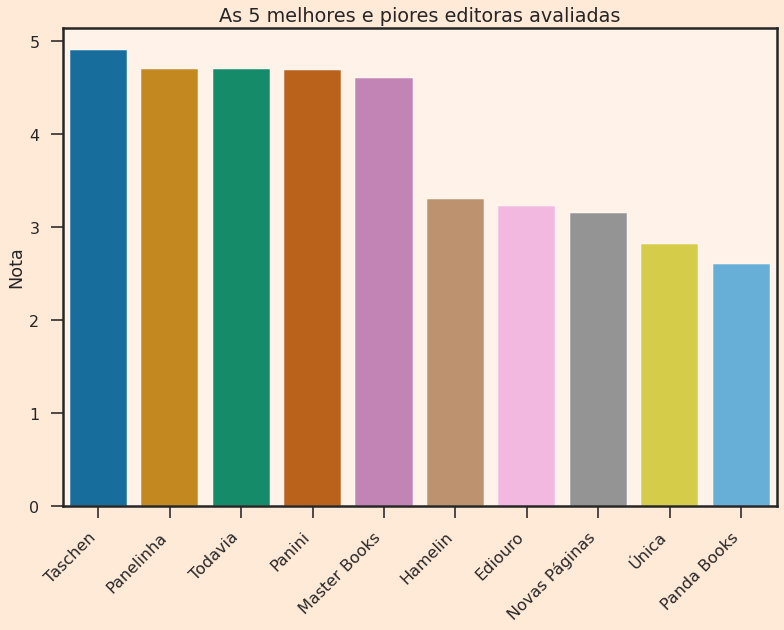

In [8]:
df_editora = pd.DataFrame(df_analise.groupby('editora').mean()['nota'].sort_values(ascending=False))
melhor_pior = pd.concat([df_editora.head(), df_editora.tail()])

ax = sns.barplot(data = df_analise, x = melhor_pior.index[:], y = melhor_pior.nota[:])

ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')

plt.title("As 5 melhores e piores editoras avaliadas")
plt.xlabel("")
plt.ylabel("Nota")
plt.show()

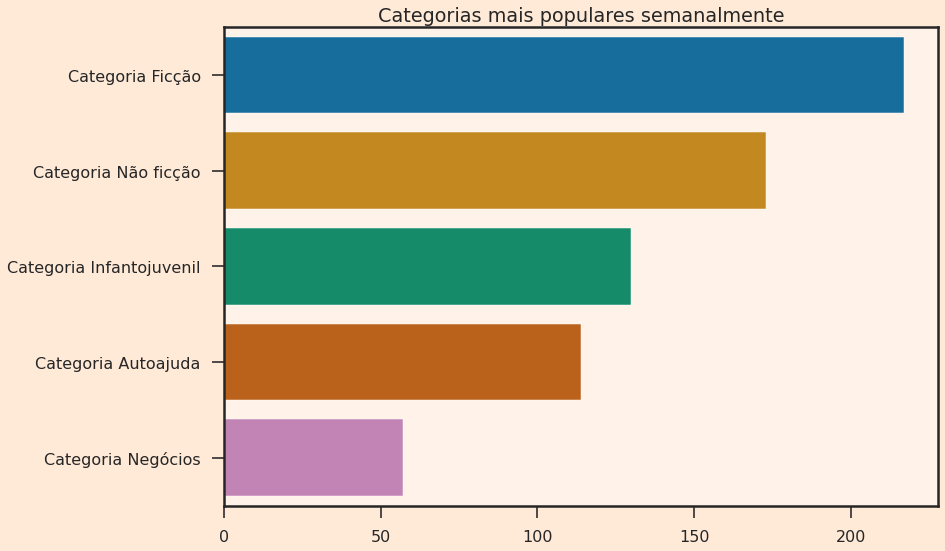

In [9]:
sns.barplot(x = df_analise.drop_duplicates(subset=['titulo']).categoria.value_counts(),
            y = df_analise.drop_duplicates(subset=['titulo']).categoria.value_counts().index)

plt.title("Categorias mais populares semanalmente")
plt.xlabel("")
plt.ylabel("")
plt.show()

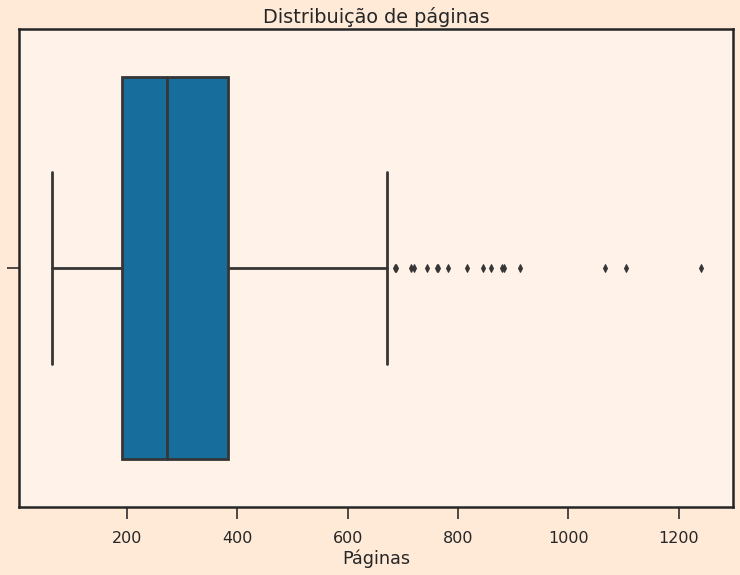

In [10]:
sns.boxplot(x = df_analise.groupby('titulo').mean()['paginas'])

plt.title("Distribuição de páginas")
plt.xlabel("Páginas")
plt.ylabel("")
plt.show()

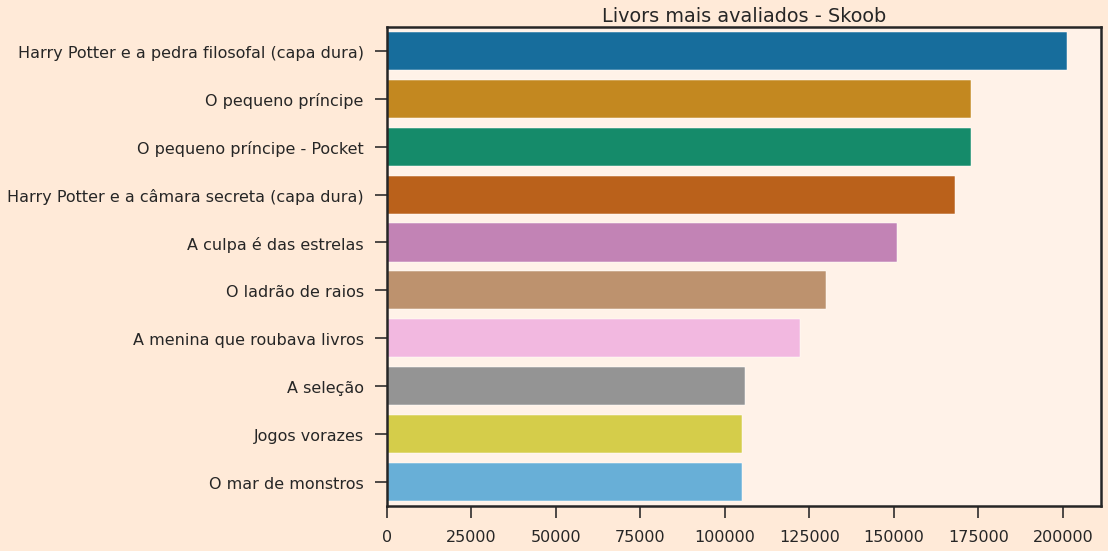

In [11]:
df_oi = df_analise.drop_duplicates(['titulo']).groupby('titulo').sum().sort_values(by=['avaliacoes'], ascending=False)[:10]

sns.barplot(y = df_oi.index[:10],
            x = df_oi.avaliacoes)

plt.title("Livors mais avaliados - Skoob")
plt.xlabel("")
plt.ylabel("")
plt.show()

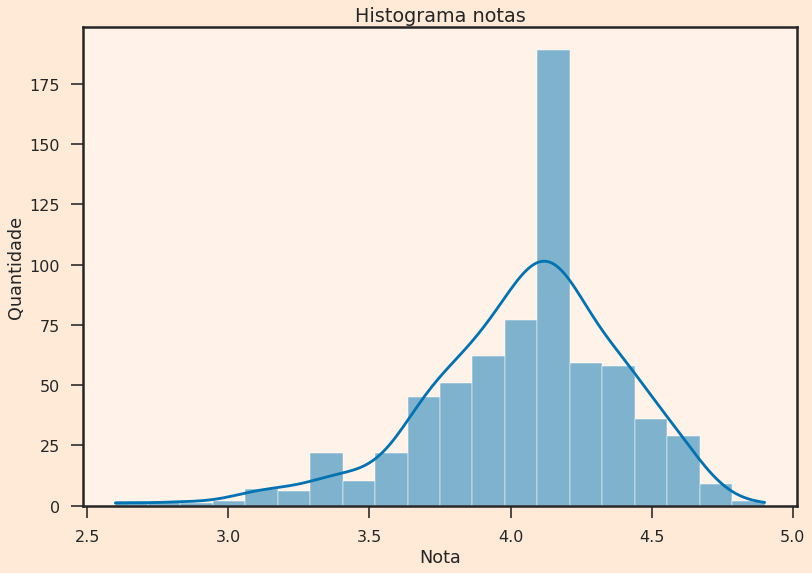

In [12]:
sns.histplot(df_analise.groupby('titulo').mean()['nota'], kde = True, bins=20)

plt.title("Histograma notas")
plt.xlabel("Nota")
plt.ylabel("Quantidade")
plt.show()

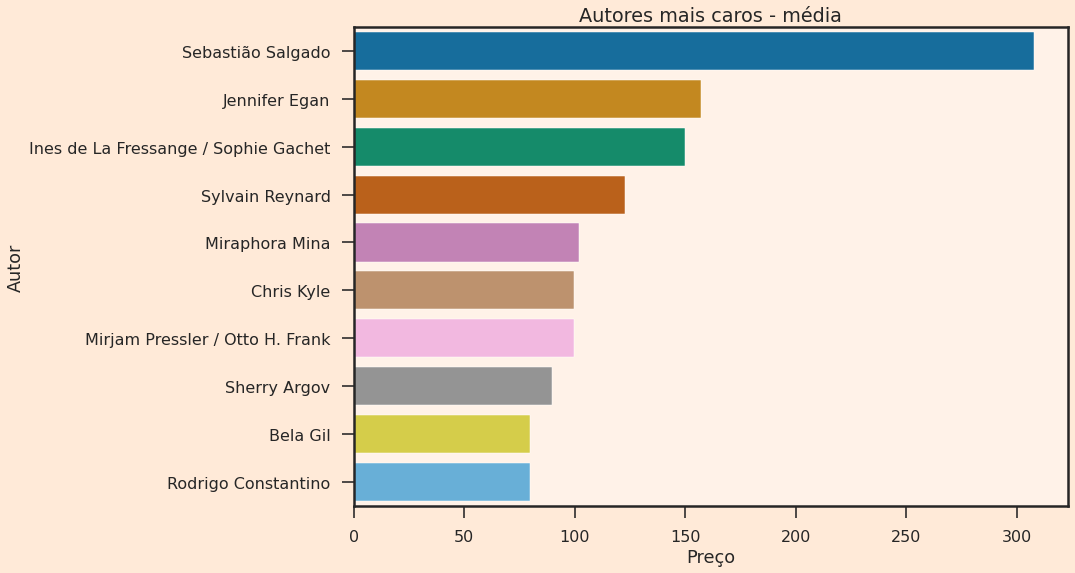

In [13]:
df_unico_autor = df_analise.drop_duplicates(subset=['titulo']).groupby('autor').mean().sort_values(by=['preco'], ascending=False)[:10]['preco']

sns.barplot(x = df_unico_autor, y = df_unico_autor.index[:10])

plt.title("Autores mais caros - média")
plt.xlabel("Preço")
plt.ylabel("Autor")
plt.show()

# Pre-processamento de dados

## Excluindo livros repetidos

In [14]:
df = df.sort_values(by=['numero de vendas'], ascending=False).drop_duplicates(subset=['titulo'],keep='first')

## Imputando valores vazios

In [15]:
from sklearn.impute import SimpleImputer
import numpy as np

imp_mean = SimpleImputer(strategy='median')

# Na coluna preco e nota, substituir os valores nulos pela mediana dos valores
imputados = pd.DataFrame(imp_mean.fit_transform(df[['preco', 'nota']]))

# juntando os dados com os dados originais

df.reset_index(drop=True, inplace=True)
df.drop(['nota', 'preco'], axis=1, inplace=True)

df = pd.concat([imputados, df], axis=1)
df.rename(columns={0: 'preco', 1: 'nota'}, inplace=True)

## Transformando a variável preço em 0 e 1 

In [16]:
df.nota = df.nota.apply(lambda x: 0 if x <= df['nota'].mean() else 1)

## Definindo as variáveis

In [17]:
X = df[['preco', 'autor', 'editora']]
y = df['nota']

## Categorical Transformations

In [18]:
from sklearn.preprocessing import OneHotEncoder

cat_variaveis = ['autor', 'editora']
X_cat = OneHotEncoder(sparse=False, handle_unknown='ignore').fit_transform(X[cat_variaveis])

## Numerical Transformations

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
import numpy as np

num_variables = ['preco']
X_num = FunctionTransformer(np.log1p).fit_transform(X[num_variables])
X_num = MinMaxScaler().fit_transform(X_num)
X_num = pd.DataFrame(X_num, columns=['preco_scaled'])

In [20]:
X = pd.concat([X_num.reset_index(drop=True), pd.DataFrame(X_cat)], axis=1)

### Visualizando os dados numéricos não normalizados

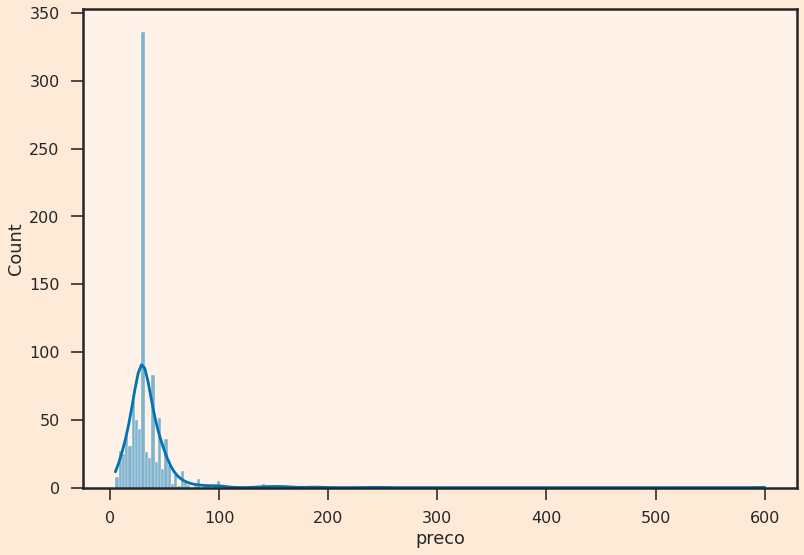

In [21]:
sns.histplot(data=df, x="preco", kde=True)
plt.show()

### Visualizando os dados numéricos normalizados

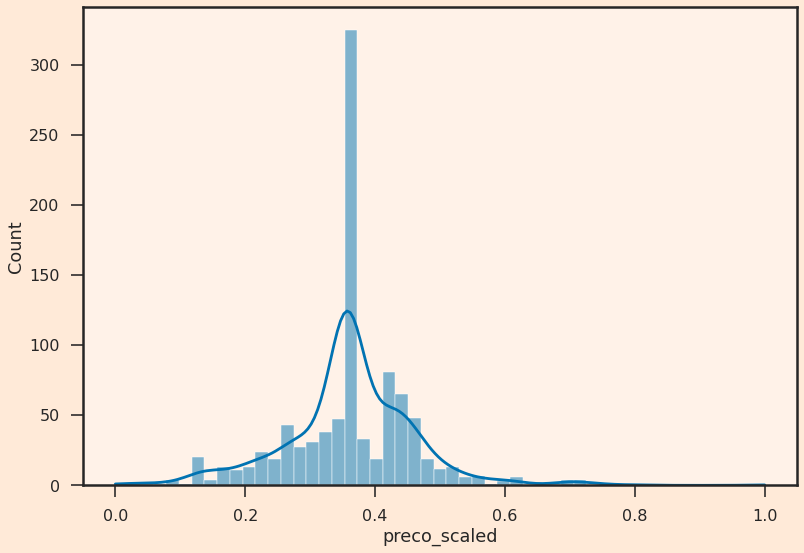

In [22]:
sns.histplot(data=X, x="preco_scaled", kde=True)
plt.show()

## Separando os dados em treinamento e teste

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=42, test_size=0.2)

# Criação dos modelos

> Para a criação dos modelos a seguir, utilizaremos o GridSearchCV, um método de busca de parâmetros que utiliza pesquisa em grade para encontrar os melhores parâmetros para cada modelo, com excessão do modelo Dummy.

## Dummy

Criando um modelo "burro" para representar o pior resultado possível, uma linha de base para comparação com os outros modelos.

In [24]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train);

### Matriz  de confusão

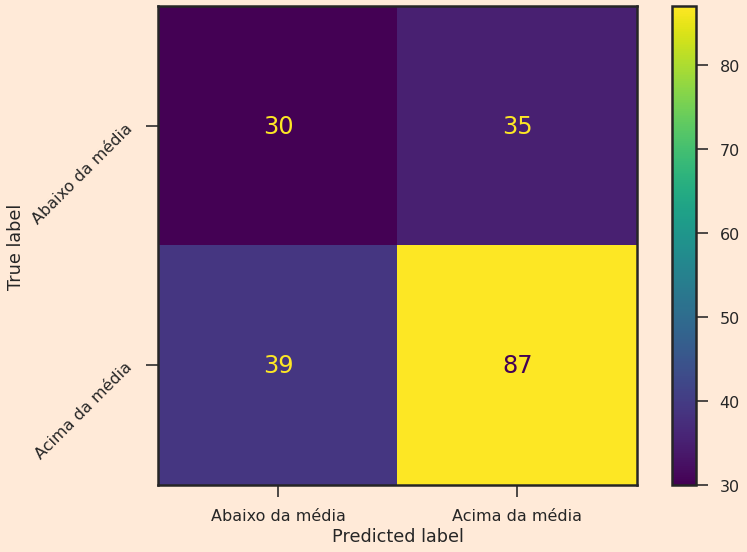

In [25]:
from sklearn.metrics import confusion_matrix

dummy_prediction = dummy.predict(X_test)
dummy_cm = confusion_matrix(y_test, dummy_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(dummy_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dummy_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
dummy_metricas["accuracy"].append(accuracy_score(y_test, dummy_prediction))
dummy_metricas["precision"].append(precision_score(y_test, dummy_prediction))
dummy_metricas["recall"].append(recall_score(y_test, dummy_prediction))
dummy_metricas["f1_score"].append(f1_score(y_test, dummy_prediction))
dummy_metricas['model'].append('Dummy')

dummy_metricas = pd.DataFrame(dummy_metricas)
dummy_metricas

,model,accuracy,precision,recall,f1_score
0,Dummy,0.612565,0.713115,0.690476,0.701613


In [27]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        dummy_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.43      0.46      0.45        65
 Livro acima da média       0.71      0.69      0.70       126

             accuracy                           0.61       191
            macro avg       0.57      0.58      0.57       191
         weighted avg       0.62      0.61      0.62       191



## KNN

No KNN, quando o valor de k é pequeno (1 ou 2), produzimos um modelo muito flexível, em que apenasd um ponto afeta totalmente o resultado, principalmente outliers, causando overfitting. Quando o valor de k é grande (maior que 10), produzimos um modelo muito restrito, em que todos os pontos afetam o resultado, podendo causar underfitting. Normalmente se escolhe para o valor de k entre 1 e 20.

Como o KNN utiliza a distância Euclidiana para se calcular a distância entre os pontos, é nececessário se escalar os dados para que as variáveis de larga escala não dominem as distâncias.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(1, 21))
weights = ['uniform', 'distance']
param_grid = dict(n_neighbors=n_neighbors, weights=weights)

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, param_grid, scoring='accuracy')
  
knn.fit(X_train, y_train)

print(knn.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [29]:
knn_param = pd.DataFrame(knn.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
knn_param['params'] = knn_param['params'].astype('string')
novo = knn_param['params'].str.split(',', expand=True)
knn_param['k'] = novo[0]
knn_param['weights'] = novo[1]
knn_param['k'] = knn_param['k'].replace("{'n_neighbors':", '', regex=True)
knn_param['weights'] = knn_param['weights'].replace("'weights': '", '', regex=True)
knn_param['weights'] = knn_param['weights'].replace("'}", '', regex=True)
knn_param['k'] = knn_param['k'].astype('int')
knn_param.drop('params', axis=1, inplace=True)

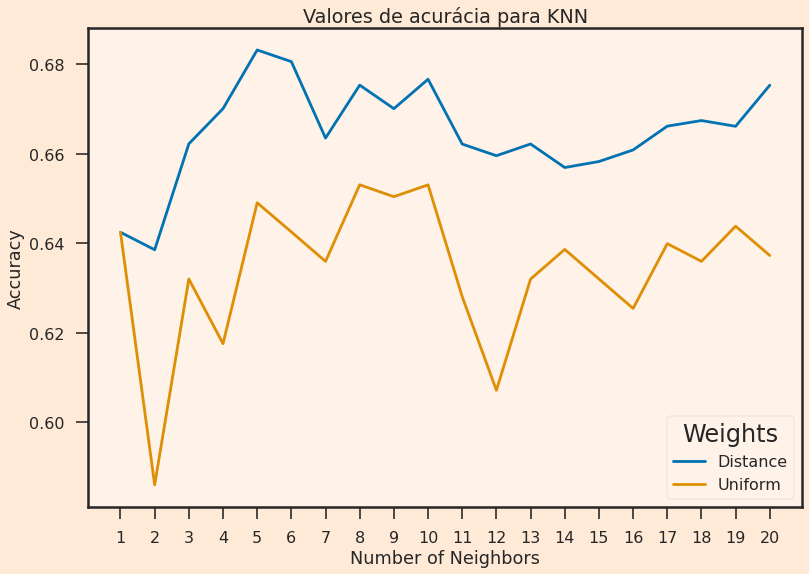

In [30]:
sns.lineplot(data=knn_param, x='k', y='mean_test_score', hue='weights')

plt.title('Valores de acurácia para KNN')

plt.ylabel('Accuracy')

plt.xlabel('Number of Neighbors')
plt.xticks(n_neighbors)

plt.legend(title='Weights', labels=['Distance', 'Uniform'], loc='lower right')

plt.show()

### Matriz de confusão

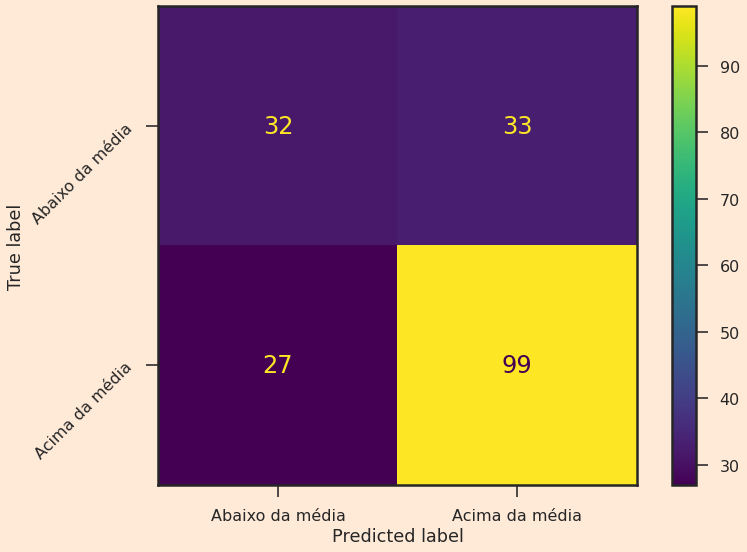

In [31]:
from sklearn.metrics import confusion_matrix

knn_prediction = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(knn_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

knn_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
knn_metricas["accuracy"].append(accuracy_score(y_test, knn_prediction))
knn_metricas["precision"].append(precision_score(y_test, knn_prediction))
knn_metricas["recall"].append(recall_score(y_test, knn_prediction))
knn_metricas["f1_score"].append(f1_score(y_test, knn_prediction))
knn_metricas['model'].append('KNN')

knn_metricas = pd.DataFrame(knn_metricas)
knn_metricas

,model,accuracy,precision,recall,f1_score
0,KNN,0.685864,0.75,0.785714,0.767442


In [33]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        knn_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.54      0.49      0.52        65
 Livro acima da média       0.75      0.79      0.77       126

             accuracy                           0.69       191
            macro avg       0.65      0.64      0.64       191
         weighted avg       0.68      0.69      0.68       191



## Regressão Logística

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_grid = dict(solver=solver)

log_reg = LogisticRegression(random_state=42)
log_reg = GridSearchCV(log_reg, param_grid, scoring='accuracy')
  
log_reg.fit(X_train, y_train)

print(log_reg.best_params_)

{'solver': 'newton-cg'}


In [35]:
log_reg_param = pd.DataFrame(log_reg.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
log_reg_param

,mean_test_score,params
0,0.64515,{'solver': 'newton-cg'}
1,0.64515,{'solver': 'lbfgs'}
2,0.64515,{'solver': 'liblinear'}
3,0.64515,{'solver': 'sag'}
4,0.64515,{'solver': 'saga'}


### Matriz de confusão

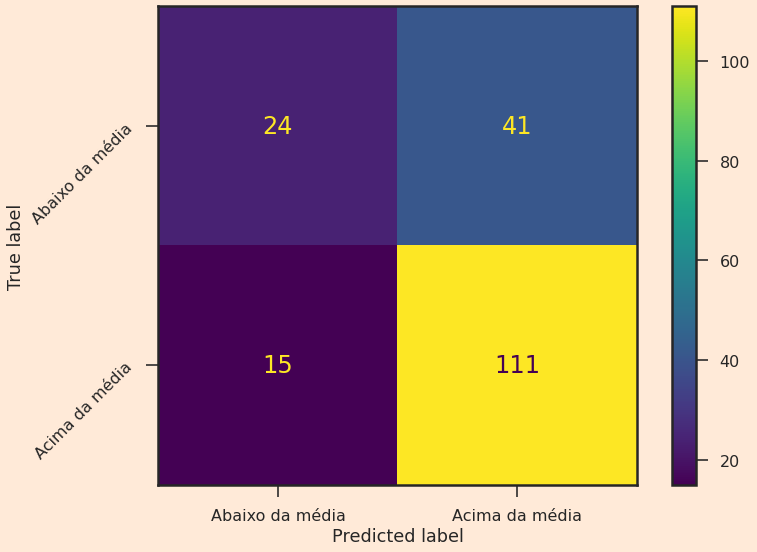

In [36]:
from sklearn.metrics import confusion_matrix

log_reg_prediction = log_reg.predict(X_test)
log_reg_cm = confusion_matrix(y_test, log_reg_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(log_reg_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

log_reg_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
log_reg_metricas["accuracy"].append(accuracy_score(y_test, log_reg_prediction))
log_reg_metricas["precision"].append(precision_score(y_test, log_reg_prediction))
log_reg_metricas["recall"].append(recall_score(y_test, log_reg_prediction))
log_reg_metricas["f1_score"].append(f1_score(y_test, log_reg_prediction))
log_reg_metricas["model"].append('Regressão Logística')

log_reg_metricas = pd.DataFrame(log_reg_metricas)
log_reg_metricas

,model,accuracy,precision,recall,f1_score
0,Regressão Logística,0.706806,0.730263,0.880952,0.798561


In [38]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        log_reg_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.62      0.37      0.46        65
 Livro acima da média       0.73      0.88      0.80       126

             accuracy                           0.71       191
            macro avg       0.67      0.63      0.63       191
         weighted avg       0.69      0.71      0.68       191



## Naive Bayes (Bernoulli)

In [39]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.7015706806282722

### Matriz de confusão

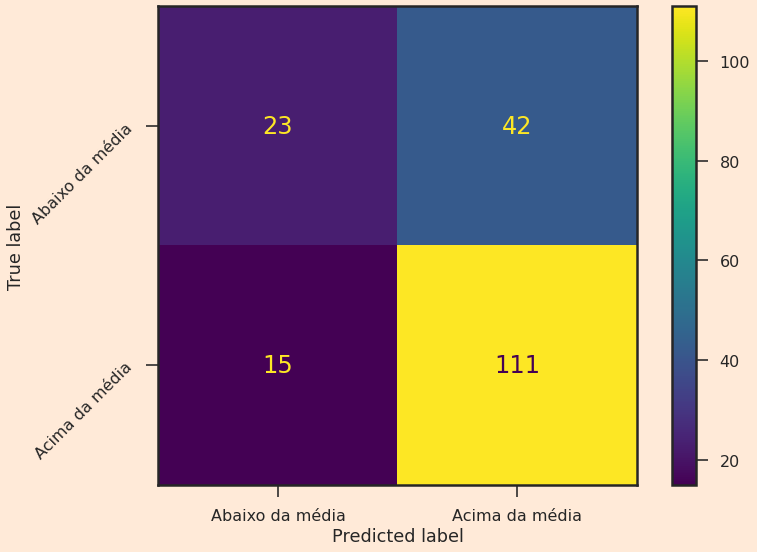

In [40]:
from sklearn.metrics import confusion_matrix

nb_prediction = nb.predict(X_test)
nb_cm = confusion_matrix(y_test, nb_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(nb_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nb_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
nb_metricas["accuracy"].append(accuracy_score(y_test, nb_prediction))
nb_metricas["precision"].append(precision_score(y_test, nb_prediction))
nb_metricas["recall"].append(recall_score(y_test, nb_prediction))
nb_metricas["f1_score"].append(f1_score(y_test, nb_prediction))
nb_metricas["model"].append('Naive Bayes')

nb_metricas = pd.DataFrame(nb_metricas)
nb_metricas

,model,accuracy,precision,recall,f1_score
0,Naive Bayes,0.701571,0.72549,0.880952,0.795699


In [42]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        nb_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.61      0.35      0.45        65
 Livro acima da média       0.73      0.88      0.80       126

             accuracy                           0.70       191
            macro avg       0.67      0.62      0.62       191
         weighted avg       0.68      0.70      0.68       191



## SVC

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
decision_function_shape = ['ovo', 'ovr']
#C = [0.1, 1, 10, 100, 1000]
#gama = [1, 0.1, 0.01, 0.001, 0.0001]
param_grid = dict(kernel=kernel, decision_function_shape=decision_function_shape)

svc = SVC(probability=True, random_state=42)
svc = GridSearchCV(svc, param_grid, scoring='accuracy')
  
svc.fit(X_train, y_train)

print(svc.best_params_)

{'decision_function_shape': 'ovo', 'kernel': 'poly'}


In [44]:
svc_param = pd.DataFrame(svc.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
svc_param['params'] = svc_param['params'].astype('string')
novo = svc_param['params'].str.split(',', expand=True)
svc_param['decision_function_shape'] = novo[0]
svc_param['kernel'] = novo[1]
svc_param['decision_function_shape'] = svc_param['decision_function_shape'].replace("{'decision_function_shape': '", '', regex=True)
svc_param['decision_function_shape'] = svc_param['decision_function_shape'].replace("'", '', regex=True)
svc_param['kernel'] = svc_param['kernel'].replace("'kernel': '", '', regex=True)
svc_param['kernel'] = svc_param['kernel'].replace("'}", '', regex=True)
svc_param.drop('params', axis=1, inplace=True)

In [45]:
svc_param.groupby(['kernel', 'decision_function_shape']).mean()

mean_test_score
kernel  decision_function_shape                 
linear  ovo                             0.671431
        ovr                             0.671431
poly    ovo                             0.672738
        ovr                             0.672738
rbf     ovo                             0.653027
        ovr                             0.653027
sigmoid ovo                             0.645141
        ovr                             0.645141

Não existe diferença no parâmetro "decision_function_shape" para o SVM

### Matriz de confusão

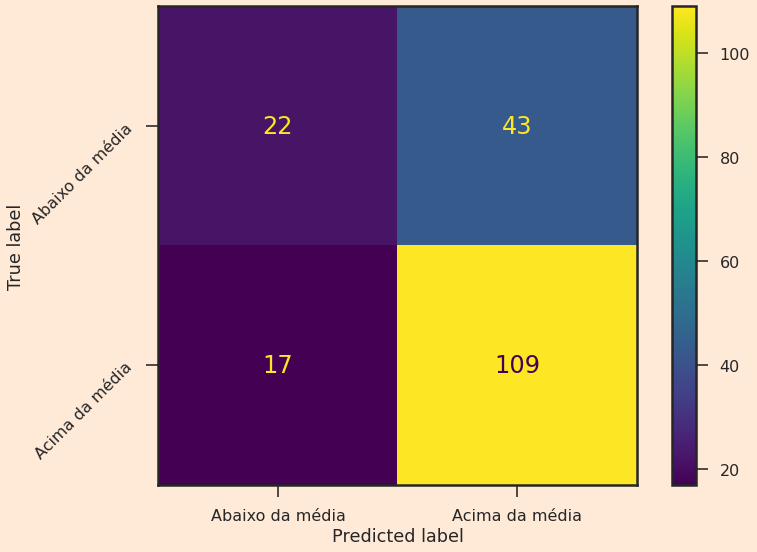

In [46]:
from sklearn.metrics import confusion_matrix

svc_prediction = svc.predict(X_test)
svc_cm = confusion_matrix(y_test, svc_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(svc_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

svc_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
svc_metricas["accuracy"].append(accuracy_score(y_test, svc_prediction))
svc_metricas["precision"].append(precision_score(y_test, svc_prediction))
svc_metricas["recall"].append(recall_score(y_test, svc_prediction))
svc_metricas["f1_score"].append(f1_score(y_test, svc_prediction))
svc_metricas["model"].append('SVC')

svc_metricas = pd.DataFrame(svc_metricas)
svc_metricas

,model,accuracy,precision,recall,f1_score
0,SVC,0.685864,0.717105,0.865079,0.784173


In [48]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        svc_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.56      0.34      0.42        65
 Livro acima da média       0.72      0.87      0.78       126

             accuracy                           0.69       191
            macro avg       0.64      0.60      0.60       191
         weighted avg       0.67      0.69      0.66       191



## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

criterion = ['gini', 'entropy', 'log_loss']
max_depths = list(range(1, 20))
param_grid = dict(criterion=criterion, max_depth=max_depths)

dtc = DecisionTreeClassifier()
dtc = GridSearchCV(dtc, param_grid, scoring='accuracy')

dtc.fit(X_train, y_train)

print(dtc.best_params_)

{'criterion': 'gini', 'max_depth': 3}


### Diagrama

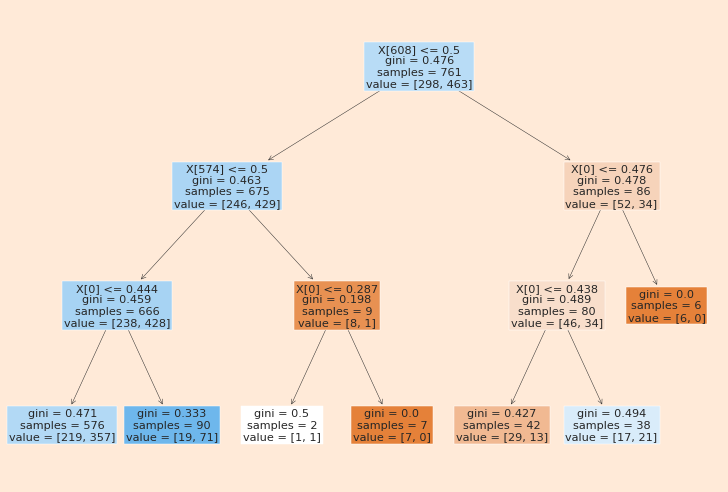

In [50]:
from sklearn import tree

arvore_bonitinha = tree.plot_tree(dtc.best_estimator_, filled=True, max_depth=3)
plt.show()

In [51]:
dtc_param = pd.DataFrame(dtc.cv_results_)[['mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)
dtc_param['params'] = dtc_param['params'].astype('string')
novo = dtc_param['params'].str.split(',', expand=True)
dtc_param['criterion'] = novo[0]
dtc_param['max_depth'] = novo[1]
dtc_param['criterion'] = dtc_param['criterion'].replace("{'criterion': '", '', regex=True)
dtc_param['criterion'] = dtc_param['criterion'].replace("'", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].replace("'max_depth': ", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].replace("}", '', regex=True)
dtc_param['max_depth'] = dtc_param['max_depth'].astype('int')
dtc_param.drop('params', axis=1, inplace=True)

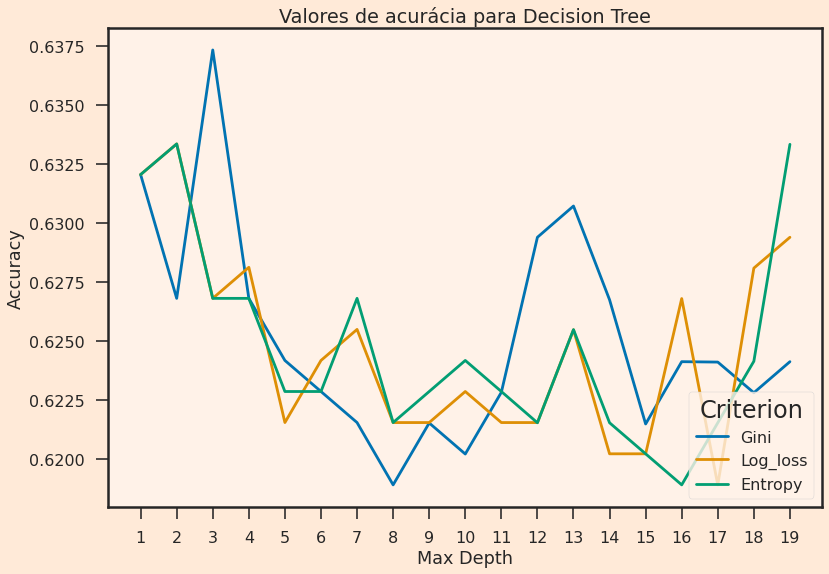

In [52]:
sns.lineplot(data=dtc_param, x='max_depth', y='mean_test_score', hue='criterion')

plt.title('Valores de acurácia para Decision Tree')

plt.ylabel('Accuracy')

plt.xlabel('Max Depth')
plt.xticks(max_depths)

plt.legend(title='Criterion', labels=['Gini', 'Log_loss', 'Entropy'], loc='lower right')

plt.show()

### Matriz de confusão

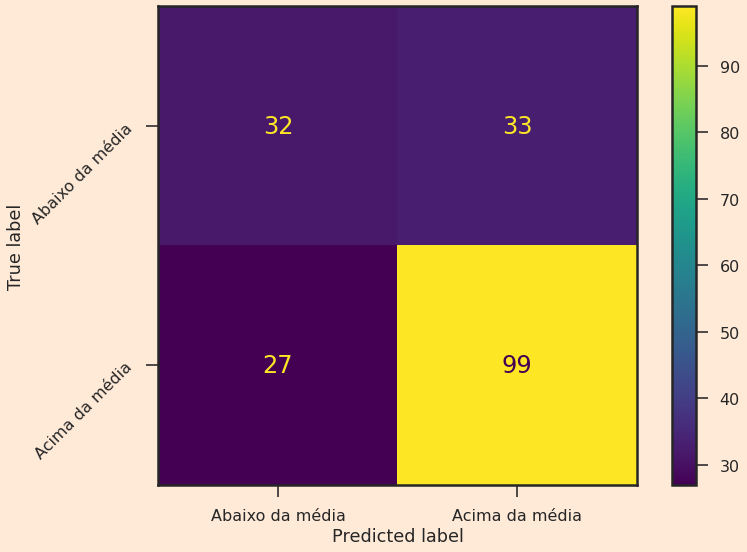

In [54]:
from sklearn.metrics import confusion_matrix

dtc_prediction = dtc.predict(X_test)
dtc_cm = confusion_matrix(y_test, knn_prediction)

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(dtc_cm, display_labels=["Abaixo da média", "Acima da média"]).plot()
plt.yticks(rotation=45)
plt.show()

### Métricas

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtc_metricas = {'model': list(), 'accuracy': list(), 'precision': list(), 'recall': list(), 'f1_score': list()}
dtc_metricas["accuracy"].append(accuracy_score(y_test, dtc_prediction))
dtc_metricas["precision"].append(precision_score(y_test, dtc_prediction))
dtc_metricas["recall"].append(recall_score(y_test, dtc_prediction))
dtc_metricas["f1_score"].append(f1_score(y_test, dtc_prediction))
dtc_metricas['model'].append('Decision Tree')

dtc_metricas = pd.DataFrame(dtc_metricas)
dtc_metricas

,model,accuracy,precision,recall,f1_score
0,Decision Tree,0.680628,0.679558,0.97619,0.801303


In [56]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test,
        dtc_prediction,
        target_names=["Livro abaixo da média", "Livro acima da média"]
    )
)

                       precision    recall  f1-score   support

Livro abaixo da média       0.70      0.11      0.19        65
 Livro acima da média       0.68      0.98      0.80       126

             accuracy                           0.68       191
            macro avg       0.69      0.54      0.49       191
         weighted avg       0.69      0.68      0.59       191



# Comparando os modelos

## Tabela

In [57]:
compara = pd.concat([dummy_metricas, knn_metricas, log_reg_metricas, nb_metricas, svc_metricas, dtc_metricas])
compara.set_index('model', inplace=True)
compara

,accuracy,precision,recall,f1_score
model,,,,
Dummy,0.612565,0.713115,0.690476,0.701613
KNN,0.685864,0.750000,0.785714,0.767442
Regressão Logística,0.706806,0.730263,0.880952,0.798561
Naive Bayes,0.701571,0.725490,0.880952,0.795699
SVC,0.685864,0.717105,0.865079,0.784173
Decision Tree,0.680628,0.679558,0.976190,0.801303


## ROC Curve

In [58]:
from sklearn.metrics import roc_auc_score

knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]).round(2)
log_reg_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]).round(2)
nb_auc = roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1]).round(2)
svc_auc = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]).round(2)
dtc_auc = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1]).round(2)
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test)[:, 1]).round(2)

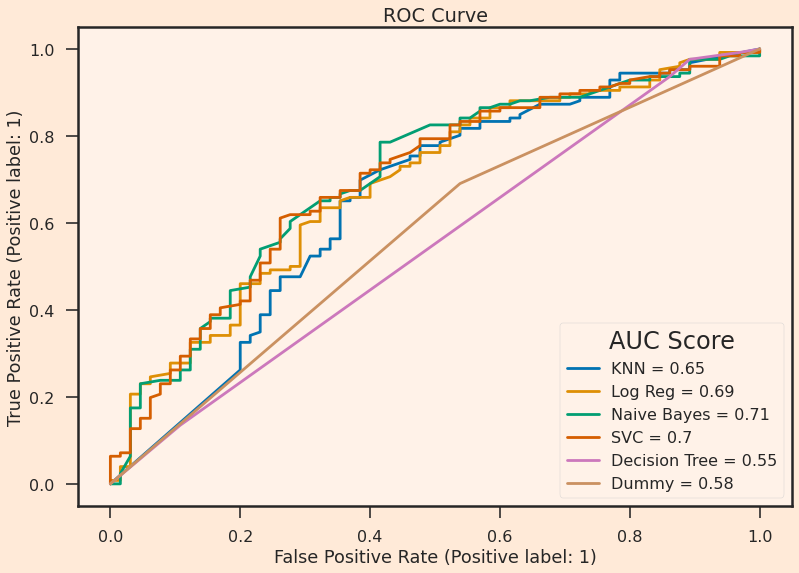

In [59]:
from sklearn.metrics import RocCurveDisplay

#knn_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test)

ax = plt.gca()

knn_disp = RocCurveDisplay.from_estimator(knn, X_test, y_test, ax=ax)
log_reg_disp = RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax)
nb_disp = RocCurveDisplay.from_estimator(nb, X_test, y_test, ax=ax)
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test, ax=ax)
dtc_disp = RocCurveDisplay.from_estimator(dtc, X_test, y_test, ax=ax)
dummy_disp = RocCurveDisplay.from_estimator(dummy, X_test, y_test, ax=ax)

plt.title('ROC Curve')

plt.legend(
    title='AUC Score',
    labels=[f'KNN = {knn_auc}', f'Log Reg = {log_reg_auc}', f'Naive Bayes = {nb_auc}', f'SVC = {svc_auc}', f'Decision Tree = {dtc_auc}',  f'Dummy = {dummy_auc}'],
    loc='lower right'
)

plt.show()

# Joblib

In [60]:
from joblib import dump

dump(knn, 'joblib/knn.joblib')
dump(log_reg, 'joblib/log_reg.joblib')
dump(svc, 'joblib/svc.joblib')
dump(dtc, 'joblib/dtc.joblib')
dump(X_test, 'joblib/X.joblib')
dump(y_test, 'joblib/y.joblib');

# Pickle

In [61]:
import pickle
s = pickle.dumps(knn)
knn2 = pickle.loads(s)
knn2.score(X_test, y_test)

0.6858638743455497